In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from queue import deque
import json
import os

In [14]:
def export_graph(theGraph, distances, path_dir):
    data_graph = nx.json_graph.node_link_data(theGraph)
    data_distances = distances.tolist()
    data = {
        'distances': data_distances,
        'graph': data_graph
    }

    with open(path_dir, 'w+') as outfile:  
        json.dump(data, outfile)

def import_graph(path_dir):
    with open(path_dir) as json_file:
        data = json.load(json_file)
        print(data['distances'])
        #print(data['graph'])
        graph = nx.json_graph.node_link_graph(data['graph'])
        return graph, data['distances']

In [7]:
def plot_graph(theGraph):
    nx.draw(theGraph)
    plt.subplot(121)
    nx.draw(theGraph, with_labels=True)
    plt.show()

In [12]:
def mount_graph():
    
    theGraph = nx.DiGraph()
    theGraph.add_node('pa1', id=1, local='A', time=1, team='pedreiro', build='A')
    theGraph.add_node('pb1', id=2, local='B', time=1, team='pedreiro', build='B')
    theGraph.add_node('pb2', id=3, local='B', time=1, team='pedreiro', build='B')

    theGraph.add_node('ea1', id=4, local='A', time=1, team='encanador', build='A')
    theGraph.add_node('ea2', id=5, local='A', time=1, team='encanador', build='A')
    theGraph.add_node('eb1', id=6, local='B', time=1, team='encanador', build='B')
    theGraph.add_node('eb2', id=7, local='B', time=1, team='encanador', build='B')
    theGraph.add_node('eb3', id=8, local='B', time=1, team='encanador', build='B')

    theGraph.add_node('la1', id=9, local='A', time=1, team='eletricista', build='A')
    theGraph.add_node('la2', id=10, local='A', time=1, team='eletricista', build='A')
    theGraph.add_node('lb1', id=11, local='B', time=1, team='eletricista', build='B')
    theGraph.add_node('lb2', id=12, local='B', time=1, team='eletricista', build='B')
    theGraph.add_node('lb3', id=13, local='B', time=1, team='eletricista', build='B')
    
    theGraph.add_edge('pa1','ea1')
    theGraph.add_edge('pa1','ea2')
    theGraph.add_edge('ea1','la1')
    theGraph.add_edge('ea2','la2')

    theGraph.add_edge('pb1','pb2')
    theGraph.add_edge('pb1','eb1')
    theGraph.add_edge('pb1','eb2')
    theGraph.add_edge('pb2','eb3')
    theGraph.add_edge('eb1','lb1')
    theGraph.add_edge('eb2','lb2')
    theGraph.add_edge('eb3','lb3')

    distances = np.zeros((2,2), dtype=int)
    distances[:] = 1

    return theGraph, distances

In [15]:
#train_csv = os.path.join(os.path.dirname(notebook_path), "Datasets/train.csv")
theGraph, distances = mount_graph()
export_graph(theGraph, distances, "/home/elvio/github/wsrp/graphs/exemplo5.txt")


[[1, 1], [1, 1]]


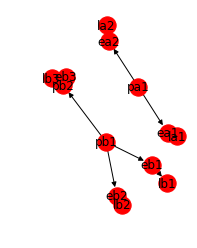

[[1, 1], [1, 1]]


In [21]:
def plot_graph(theGraph):
    nx.draw(theGraph)
    plt.subplot(121)
    nx.draw(theGraph, with_labels=True)    
    plt.show()

theGraph, distances = import_graph("/home/elvio/github/wsrp/graphs/exemplo5.txt")

plot_graph(theGraph)
print(distances)

In [25]:
def topological_sort(theGraph):
    
    topSort = []
    q = deque() 

    for edge in theGraph.in_degree:
        if edge[1] == 0:
            q.appendleft(edge[0])
    
    while q:
        node = q.pop()
        topSort.append(node)
        for adj in theGraph.adj[node]:
            if adj not in q:
                q.appendleft(adj)
    
    return topSort

order = topological_sort(theGraph)
print(order)

['pa1', 'pb1', 'ea1', 'ea2', 'pb2', 'eb1', 'eb2', 'la1', 'la2', 'eb3', 'lb1', 'lb2', 'lb3']


In [27]:
def show_schedule(schedules):
    print('ordenação topologica:')
    print(order, '\n')
    print('matriz de schedules:')
    
    for i in range(len(schedules)):
        print('dia:', i+1)
        for activity in schedules[i]:
            print('\t', activity, theGraph.nodes[activity]['local'], theGraph.nodes[activity]['team'])

In [35]:
def generate_wsrp_matrix(theGraph, order):
    
    n_nodes = len(theGraph)
    for i in range(n_nodes):
        node = theGraph.nodes[order[i]] 
        node['scheduled'] = False
        
    teams = {}
    for i in range(n_nodes):
        teams.update({theGraph.nodes[order[i]]['team']: {'working': False, 'traveling':False, 'local':''}})
        node = theGraph.nodes[order[i]]
    
    for team in teams:
        print(team, teams[team])
        
    schedules = []
    day = []
    working = []
    
    for i in range(n_nodes):
        #print('--------------------')
        #print(theGraph.nodes[order[i]])
        current_node = theGraph.nodes[order[i]]
        if not current_node['scheduled']:
            
            teams_day = []
            day.append(order[i])
            teams_day.append(current_node['team'])
            for j in range(i, n_nodes):
                #print('\t', order[j], theGraph.nodes[order[j]])
                if theGraph.nodes[order[j]]['team'] not in teams_day and not theGraph.nodes[order[j]]['scheduled']:
                    previous = theGraph.out_degree[order[j]]
                    to_schedule = True
                    #print('previous', previous)
                    for previous in theGraph.pred[order[j]]:
                        #print(theGraph.nodes[previous])
                        if not theGraph.nodes[previous]['scheduled']:
                            to_schedule = False
                            break
                    if to_schedule:
                        #print('insere grafo:', order[j])
                        #print(current_node['team'], theGraph.nodes[order[j]]['team'])
                        day.append(order[j])
                        teams_day.append(theGraph.nodes[order[j]]['team'])
            #print(day)
            for node in day:
                theGraph.nodes[node]['scheduled'] = True

            schedules.append(day)
    return schedules

schedules = generate_wsrp_matrix(theGraph, order)

pedreiro {'working': False, 'traveling': False, 'local': ''}
encanador {'working': False, 'traveling': False, 'local': ''}
eletricista {'working': False, 'traveling': False, 'local': ''}


In [ ]:
show_schedule(schedules)